In [13]:
import _pickle as pkl
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import utils as ut

# First view

## Data loading and basic analysis

Looking through the data bring us to the point that all features are not expressed in mean (__mean__ $\simeq 0$). Thus, a common sample will have only few non-zero features and be at a distance from points of other classes. This pecularity of points distribution shows it is worth trying classification tree approach here.  

In [14]:
sample = pd.read_csv("sampleSubmission.csv")
train  = pd.read_csv("train.csv")
test   = pd.read_csv("test.csv")

train.drop(columns='id', inplace=True)
test.drop(columns='id', inplace=True)
train.target.replace('Class_', '', inplace=True, regex=True)
train.target = train.target.astype('int')
train.describe(percentiles=[])

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
count,61878.00000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,...,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000
mean,0.38668,0.263066,0.901467,0.779081,0.071043,0.025696,0.193704,0.662433,1.011296,0.263906,...,0.532306,1.128576,0.393549,0.874915,0.457772,0.812421,0.264941,0.380119,0.126135,4.842335
std,1.52533,1.252073,2.934818,2.788005,0.438902,0.215333,1.030102,2.255770,3.474822,1.083340,...,1.900438,2.681554,1.575455,2.115466,1.527385,4.597804,2.045646,0.982385,1.201720,2.510794
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
max,61.00000,51.000000,64.000000,70.000000,19.000000,10.000000,38.000000,76.000000,43.000000,30.000000,...,55.000000,65.000000,67.000000,30.000000,61.000000,130.000000,52.000000,19.000000,87.000000,9.000000


## Inbalance of target classes

By checking out the targets distribution in _train_ dataset we can find the inbalance in classes. Therefore, it should be taken into account while estimating the classification error in future.

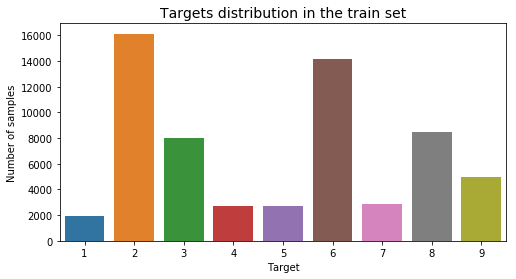

In [15]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(8, 4))
sns.countplot(x="target", data=train, ax=axes)
axes.set_title("Targets distribution in the train set", fontsize=14)
axes.set_xlabel("Target")
axes.set_ylabel("Number of samples")
plt.show()

# Features analysis

## Median features pecularities

As it follows from the underlying plot, each target class can be represented by its exclusive median features set. Thereby, target classes can be splitted into several easily-distinguishable clusters (e.g., targets 2, 3, 4) with similar classes in each of them. In this way the main goal is to be able to differ points in one cluster from each other.

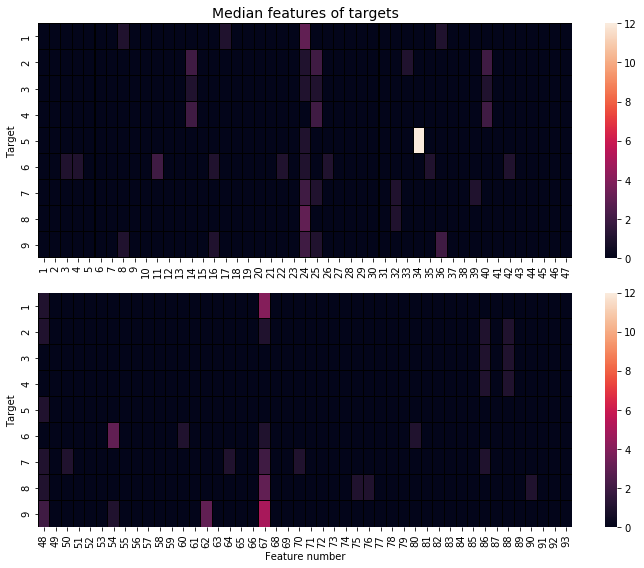

In [16]:
targets = {}
md = np.empty((9, len(train.columns)-1))
for i in range(1, 10):
    targets[i] = train[train.target == i].drop(columns='target')
    md[i-1] = targets[i].median()
    
ut.stacked_heatmap(2, md, xlabel="Feature number", ylabel="Target",
                title="Median features of targets",
                xticks=range(1, md.shape[1] + 1), yticks=range(1, 10))

## Non-zero features importance

Futher investigation can be done into non-zero features distribution. It was already mentioned that most of mean features are near zero. The magnitute of each future is not as important as its inequality to zero, thus we can think of _importance_ of every feature for given class as number of samples with this feature expressed. 

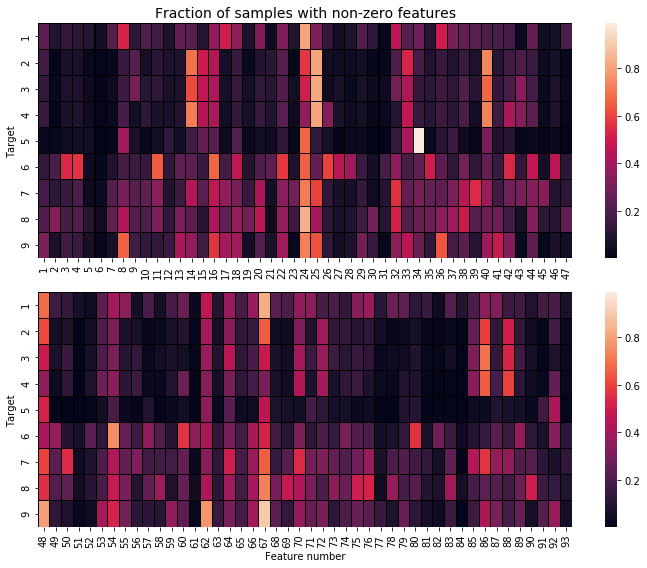

In [17]:
non_zero_count = train.replace(0, np.nan).groupby(by='target').count()
#total_count = non_zero_count.max(axis=1)
total_count = train.target.value_counts()

importance = non_zero_count.div(total_count, axis=0)
ut.stacked_heatmap(2, importance, xlabel="Feature number", ylabel="Target",
                title="Fraction of samples with non-zero features",
                xticks=range(1, importance.shape[1] + 1), yticks=range(1, 10))

## Clustering of target classes

### Clustering quality
Now let's split target classes into several clusters according to the likelihood of features _importance_ distribution. _Quality of clustering_ $Q$ is introduced as a measure of clusters' uniqueness and given by:

$$
Q = \min_{v \in V}\min_{c \in C,\;c \not= c_v}\frac{d(v, c_v)}{d(v, c)},
$$
where $V$ are all clustered vectors, $C$ are all clusters, $c_v$ is cluster correspondent to vector $v$, $d(\cdot, \cdot)$ is distance between vector and cluster center.

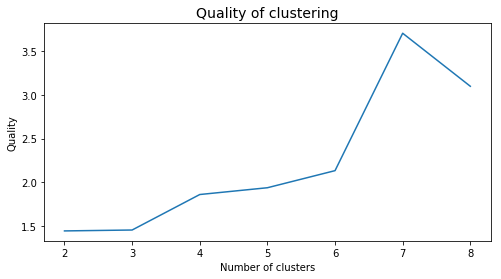

In [18]:
from sklearn.cluster import KMeans
qual = []
for i in range(2, 9):
    clustered = KMeans(n_clusters=i).fit_transform(importance)
    qual.append(ut.cluster_quality(clustered))
    
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(8, 4))
axes.set_title("Quality of clustering", fontsize=14)
axes.set_xlabel("Number of clusters")
axes.set_ylabel("Quality")
axes.plot(range(2,9), qual)
plt.show()

### Performing clustering

First rise can be seen at $n=4$ and this $n$ is small enough to prevent overfitting as we have 9 classes overall. After selection of optimal clusters number we can perform the clustering itself. As it has been already noticed, classes 2, 3, 4 are placed in one cluster.

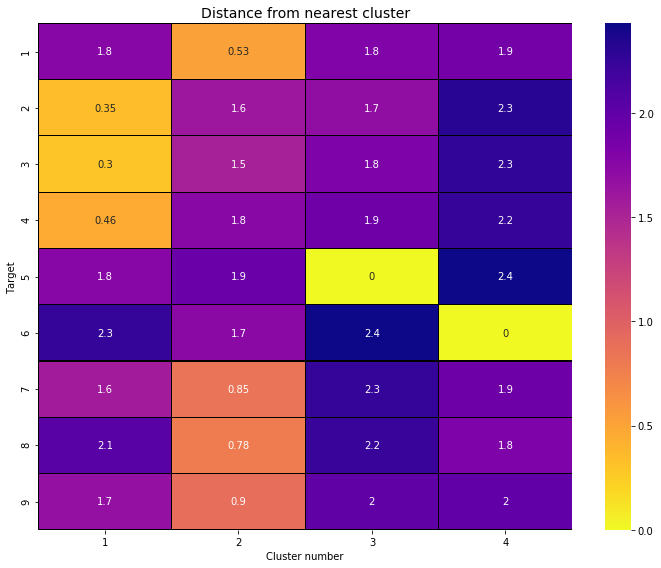

In [30]:
clustered = KMeans(n_clusters=4).fit_transform(importance)

ut.stacked_heatmap(1, clustered, xlabel="Cluster number", ylabel="Target",
                title="Distance from nearest cluster",
                xticks=range(1, clustered.shape[1] + 1), yticks=range(1, 10),
                annot=True, cmap='plasma_r')

### Analysing clusters

Let's take a look on the data after clusterization performed.

In [20]:
train_cl = train.assign(target=train.target.copy())
class_map = {1:[1, 7, 8, 9], 
             2:[2, 3, 4], 
             3:[5], 
             4:[6]}

for new, old in class_map.items():
    train_cl.target[np.isin(train.target, old)] = new

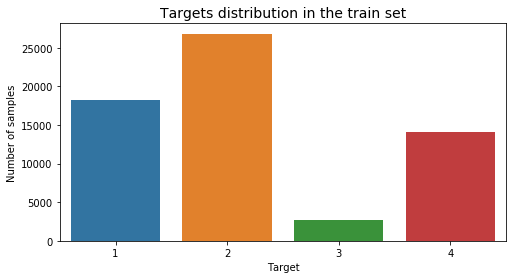

In [21]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(8, 4))
sns.countplot(x="target", data=train_cl, ax=axes)
axes.set_title("Targets distribution in the train set", fontsize=14)
axes.set_xlabel("Target")
axes.set_ylabel("Number of samples")
plt.show()

New target classes are much more easily distinguishable. Class 3 has least members of all, but it also has most expressed feature (feat_34).

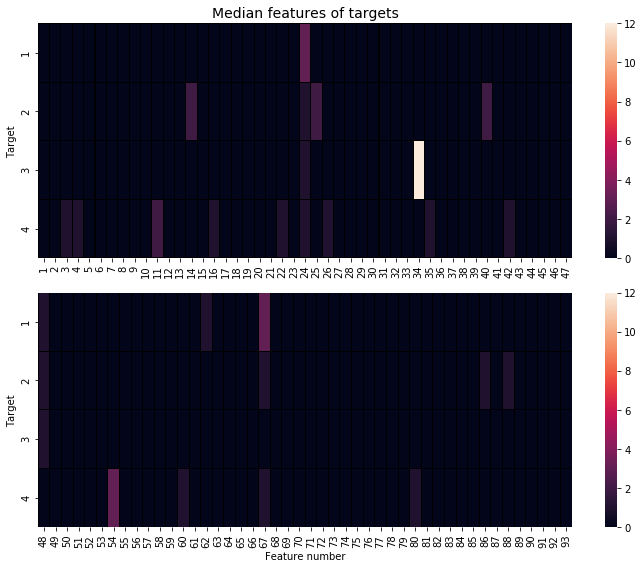

In [22]:
targets = {}
md = np.empty((len(class_map), len(train_cl.columns)-1))
for i in range(1, len(class_map) + 1):
    targets[i] = train_cl[train_cl.target == i].drop(columns='target')
    md[i-1] = targets[i].median()

ut.stacked_heatmap(2, md, xlabel="Feature number", ylabel="Target",
                title="Median features of targets",
                xticks=range(1, md.shape[1] + 1), yticks=range(1, len(class_map) + 1))

# Classification

## Out of the box performance 

Let's try to use _Random Forest_ and _k-Nearest Neighbours_ approaches on the raw data first. Scoring in use is F1, so we will trace both precision and recall. _Macro_ weightening is done to prevent error underestimation on minor classes (e.g., 1, 4, 5, 7), that means that F1 score will be evaulated for every class and then averaged among all classes without weightening.
$$
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}
$$

In [23]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as mt
from sklearn.model_selection import train_test_split

clf_tree = RandomForestClassifier(n_estimators=75, n_jobs=-1)
ut.cross_val_F1(clf_tree, train.drop(columns='target'), train.target)

X_train, X_test, y_train, y_test = train_test_split(train.drop(columns='target'),
                                                    train.target)
clf_tree.fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)
print(mt.classification_report(y_test, y_pred))

with open('tree_dumped.pkl', 'wb') as f:
    pkl.dump(clf_tree, f) 

F1 = 0.75 ± 0.00
             precision    recall  f1-score   support

          1       0.77      0.41      0.54       479
          2       0.71      0.88      0.79      4064
          3       0.63      0.49      0.55      1993
          4       0.81      0.43      0.56       673
          5       0.98      0.96      0.97       733
          6       0.94      0.94      0.94      3508
          7       0.79      0.58      0.66       692
          8       0.87      0.94      0.90      2127
          9       0.84      0.88      0.86      1201

avg / total       0.81      0.81      0.80     15470



In [24]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(metric='braycurtis', n_neighbors=5, n_jobs=-1)
ut.cross_val_F1(clf_knn, train.drop(columns='target'), train.target)

F1 = 0.75 ± 0.00


## Performance after clustering

First of all the accuracy of clustering should be tested. This can be done by measuring the same F1 score on the newly formed clusters.

In [25]:
clf_tree = RandomForestClassifier(n_estimators=30, n_jobs=-1)
ut.cross_val_F1(clf_tree, train_cl.drop(columns='target'), train_cl.target)

F1 = 0.92 ± 0.02


In [26]:
clf_knn = KNeighborsClassifier(metric='braycurtis', n_neighbors=5, n_jobs=-1)
ut.cross_val_F1(clf_knn, train_cl.drop(columns='target'), train_cl.target)

F1 = 0.90 ± 0.04


As expected, the F1 score is quite high. The one thing left is to be able to split samples from each of this clusters into subclasses.

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as mt

skf = StratifiedKFold(shuffle=True)
xtrain = train.drop(columns='target')
ytrain = train.target

F1 = []
for train_index, test_index in skf.split(xtrain, ytrain):
    X = xtrain.iloc[train_index]
    y = ytrain.iloc[train_index]
    X_test = xtrain.iloc[test_index]
    y_test = ytrain.iloc[test_index]
    
    clf = RandomForestClassifier(n_estimators=75, n_jobs=-1)
    y_cl = y.copy()
    y_test_cl = y_test.copy()
    for new, old in class_map.items():
        y_cl.iloc[np.isin(y, old)] = new
        y_test_cl.iloc[np.isin(y_test, old)] = new
    clf.fit(X, y_cl)
    subclf = {}
    for new, old in class_map.items():
        if len(old) == 1:
            continue
        subclf[new] = RandomForestClassifier(n_estimators=75, n_jobs=-1)
        idx = (y_cl.values == new)
        subclf[new].fit(X.iloc[idx], y.iloc[idx])
        y_pred = subclf[new].predict(X.iloc[idx])
    
    y_pred_tmp = clf.predict(X_test)
    y_pred = np.empty_like(y_test)
    for new, old in class_map.items():
        idx = (y_pred_tmp == new)
        if len(old) == 1:
            y_pred[idx] = old[0]
            continue 
        y_pred[idx] = subclf[new].predict(X_test.iloc[idx])
    F1.append(mt.f1_score(y_test, y_pred, average='macro'))

F1 = np.array(F1)
print('F1 = %.2f \u00b1 %.2f' % (F1.mean(), F1.std()))
print(mt.classification_report(y_test, y_pred))

F1 = 0.75 ± 0.00
             precision    recall  f1-score   support

          1       0.73      0.42      0.53       643
          2       0.71      0.87      0.78      5374
          3       0.62      0.49      0.55      2668
          4       0.83      0.44      0.58       897
          5       0.98      0.95      0.97       913
          6       0.96      0.92      0.94      4711
          7       0.74      0.60      0.67       946
          8       0.85      0.94      0.89      2821
          9       0.82      0.90      0.86      1651

avg / total       0.80      0.80      0.79     20624



As we see, the score is the same as it was without clustering :(

# Results

Now we are going to load the model created and use it to predict classes for the _test_ dataset. 

In [28]:
with open('tree_dumped.pkl', 'rb') as f:
    clf_tree = pkl.load(f)

y = clf_tree.predict_proba(test)
res = pd.DataFrame(y)
res.insert(0, 'id', range(1, y.shape[0] + 1))
new_names = {}
for i in range(9):
    new_names[i] = 'Class_' + str(i+1)
res.rename(columns=new_names, inplace=True)
res.to_csv('results.csv', index=False)

Features considered most important by random forest classifier. Have nothing to do with the heatmaps above.

Top 5 important features: 33 59 10 39 25


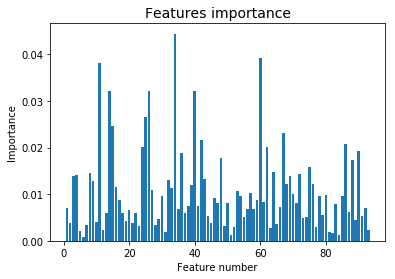

In [29]:
ind = np.argsort(clf_tree.feature_importances_)
print('Top 5 important features:', *ind[:-6:-1])
plt.bar(range(1, 94), clf_tree.feature_importances_)
plt.title('Features importance', fontsize=14)
plt.xlabel('Feature number')
plt.ylabel('Importance')
plt.show()

__Kaggle__ scores this approach as __0.62795__ and it's also quite sad. Average __F1__ achieved by random forest classifier is __0.75__.

Milestones of the analysis:
+ Inbalanced classes
+ Importance of the feature is correspondent with the fraction of samples with this future expressed (not equal to zero) 
+ Some of the classes can be aggregated into common clusters
+ Classes in one cluster are hardly distinguishable, thus data pre-clustering doesn't help the classification
+ Random forest alone gives the best result (both time and accuracy) compared to other classifiers (KNN, SGD, Decision Tree, SVC (with linear kernel))
+ The metric chosen (F1) meets the requirements of multi-class classification while allowing to trace both recall and precision; macro averaging helps not to neglect errors on minor classes
+ Sparse features distribution makes it hard to select the most important one, what is also proved by the importance value evaluated by the random forest classifier 